# Notebook 03: Detección de cambios

### Implementación y comparación de métodos de detección de cambios entre fechas.

Este notebook detecta y visualiza cambios urbanos multitemporales utilizando índices espectrales calculados previamente. En específico, implementa los siguientes métodos en el área de estudio (Viña del Mar) durante el periodo 2019-2025, con el sistema de coordenadas ESPG:32719 (UTM Zona 19S):

1. **Método 1:** Diferencia simple de NDVI entre fechas
2. **Método 2:** Clasificación de tipos de cambio (urbanización, vegetación, agua)
3. **Método 3:** Análisis de anomalías temporales mediante Z-Score

Además, se hizo una validación con datos externos (Google Dynamic World)

### Definición y justificación de umbrales (Thresholds)

Para diferenciar cambios reales de variaciones naturales (ruido del sensor, fenología estacional o condiciones atmosféricas), se establecieron umbrales espectrales estrictos basados en la literatura de teledetección para zonas semiáridas.

A continuación se detallan los parámetros utilizados en el script `detect_changes.py`:

| Método | Parámetro / Umbral | Valor | Justificación Técnica |
| :--- | :--- | :--- | :--- |
| **1. Diferencia Simple** | $\Delta$ NDVI (Magnitud de cambio) | **> 0.15** | Un cambio menor a 0.15 en NDVI suele atribuirse a variaciones fenológicas leves (una planta un poco más verde o seca) o ruido atmosférico residual. El umbral de **0.15** filtra este "ruido de fondo", asegurando que solo se detecten cambios de cobertura significativos. |
| **2. Clasificación Urbana** | Máscara vegetación (NDVI) | **> 0.3** | Se considera "Vegetación" a todo píxel con NDVI superior a 0.3. Valores inferiores (0.1 - 0.2) en Viña del Mar suelen ser suelo desnudo o vegetación muy dispersa que genera confusión. |
| **2. Clasificación Urbana** | Máscara construida (NDBI) | **> 0.0** | El Índice de Construcción Normalizado (NDBI) tiende a ser positivo en superficies impermeables y negativo en vegetación. El corte en **0.0** es el estándar físico para separar ambas coberturas. |
| **3. Anomalías** | Z-Score (Desviación estándar) | **> 2.0, < -2.0** | En una distribución normal, el 95% de los datos está dentro de 2 desviaciones estándar ($\sigma$). Cualquier valor fuera de este rango ($Z < -2$ o $Z > 2$) tiene una probabilidad menor al 5% de ocurrir por azar, considerándose una **anomalía estadística significativa** (evento extremo). |

> **Nota:** Estos umbrales fueron calibrados considerando que el análisis se realiza exclusivamente en **verano**, lo que reduce la variabilidad natural de la vegetación anual y permite ser más estricto en la detección.

##### **1) Importación de librerías y configuración de rutas**

A continuación, se cargan todas las librerías necesarias y se configura la estructura de directorios del proyecto.

In [6]:
# --- LIBRERÍAS ESTÁNDAR DE PYTHON ---
import os # Para las operaciones del sistema operativo (variables de entorno, rutas)
import sys # para el acceso a parámetros del sistema (para agregar rutas al path de Python)

# --- LIBRERÍAS DE PROCESAMIENTO GEOESPACIAL ---
import rasterio # para la lectura y escritura de archivos raster (GeoTIFF)
import numpy as np # para operaciones numéricas con arrays multidimensionales
import geopandas as gpd # para la manipulación de datos vectoriales geoespaciales

# --- LIBRERÍAS DE VISUALIZACIÓN ---
import matplotlib.pyplot as plt # para la creación de gráficos y visualizaciones
import matplotlib.colors as mcolors # para la definición de mapas de colores personalizados

# --- UTILIDADES ---
import subprocess # para la ejecución de scripts externos desde Python
from pathlib import Path # para manipular rutas de archivos de forma multiplataforma
from rasterio.plot import show # para visualizar rasters rápidamente

# Configuración de rutas y directorios del proyecto:
# Define la raíz del proyecto (directorio padre del notebook)
project_root = Path("..").resolve()
# Agrega el proyecto al path para poder importar módulos propios
sys.path.append(str(project_root))

# Directorio con los índices espectrales procesados
processed_dir = project_root / "data" / "processed"
# Directorio con archivos vectoriales (límites, manzanas, etc.)
vector_dir = project_root / "data" / "vector"
# Diccionario con directorios de salida organizados por tipo
output_dirs = {
    "figures": project_root / "outputs" / "figures",  # Gráficos estadísticos
    "maps":    project_root / "outputs" / "maps",     # Mapas georreferenciados
    "reports": project_root / "outputs" / "reports"   # Tablas y reportes CSV
}

# Carga el límite comunal para enmarcar las visualizaciones
gdf_limite = gpd.read_file(vector_dir / "limite_comuna.gpkg")

# Mensaje de confirmación de configuración exitosa
print(f"✔  Directorio de trabajo: {project_root}")

✔  Directorio de trabajo: D:\laboratorio_cambio_urbano


##### **2) Ejecución del script de detección de cambios**

A continuación, se ejecuta el script `detect_changes.py` que implementa los 3 métodos de detección de cambios descritos en el enunciado del laboratorio. Y se generan los siguientes archivos de salida:

- `cambio_diferencia_indices_2019_2025.tif` (**Método 1:** Diferencia Simple)
- `cambio_urbano_2019_2025.tif` (**Método 2:** Clasificación Urbana)
- `anomalia_temporal_2025.tif` (**Método 3:** Z-Score Histórico)

In [7]:
# Años de inicio y fin del análisis multitemporal
YEAR_START = 2019  # Año base (antes de los cambios principales)
YEAR_END = 2025    # Año objetivo (estado actual)

print(f"➤ Ejecutando detección de cambios entre {YEAR_START} y {YEAR_END}...")

# Construye la ruta al script de detección de cambios
script_path = project_root / "scripts" / "detect_changes.py"

# Construye el comando a ejecutar como lista de argumentos
cmd = [
    sys.executable,      # Usa el mismo intérprete Python del kernel activo
    str(script_path),    # Ruta al script
    "--t1", str(YEAR_START),  # Argumento: año inicial
    "--t2", str(YEAR_END),    # Argumento: año final
    "--method", "all"         # Ejecutar todos los métodos (diff, urban, anomaly)
]

# Ejecuta el script como subproceso y captura la salida
result = subprocess.run(cmd, capture_output=True, text=True, encoding="utf-8", errors="replace")

# Verifica el resultado de la ejecución
if result.returncode == 0:
    print("✔ Procesamiento Exitoso.")
    # Muestra la salida estándar del script (estadísticas y logs)
    print("\n--- SALIDA DEL SCRIPT ---")
    print(result.stdout)
else:
    # Si hubo error, muestra el mensaje de error
    print("✘ Error en el script:")
    print(result.stderr)

➤ Ejecutando detección de cambios entre 2019 y 2025...
✔ Procesamiento Exitoso.

--- SALIDA DEL SCRIPT ---
➤ Iniciando Detección de Cambios: 2019 -> 2025
--- Ejecutando Método 1: Diferencia Simple (Banda 1) ---
Ganancia (> 0.15): 52877 px (4.4%)
Pérdida (< -0.15): 101454 px (8.4%)
✔ Guardado: cambio_diferencia_indices_2019_2025.tif
--- Ejecutando Método 2: Clasificación Urbana ---
Clase Urbanización: 58222 px (~582.2 ha)
Clase Pérdida Veg: 31134 px (~311.3 ha)
Clase Ganancia Veg: 123322 px (~1233.2 ha)
Clase Nuevo Agua: 1445 px (~14.5 ha)
✔ Guardado: cambio_urbano_2019_2025.tif
--- Ejecutando Método 3: Anomalías Temporales (Target: 2025) ---
✔ Guardado: anomalia_temporal_2025.tif

✔ ✔ Proceso finalizado. Resultados en D:\laboratorio_cambio_urbano\data\processed



##### **3) Visualización del método 1: Diferencia simple de NDVI**

En esta parte se genera un mapa que muestra los cambios de vegetación detectados mediante la resta simple de NDVI (T2 - T1), en otras palabras, se resta el índice de vegetación final (2025) menos el inicial (2019).

Interpretación del mapa:
- **Rojo (-1):** Pérdida de vegetación (NDVI disminuyó > 0.15)
- **Gris (0):** Sin cambio significativo
- **Verde (+1):** Ganancia de vegetación (NDVI aumentó > 0.15)

El mapa de salida se guarda en: `outputs/maps/03_mapa_diferencia_simple.png`

##### Análisis del mapa del método 1:

El resultado clasificado en el mapa muestra una dinámica territorial compleja y heterogénea, la cual está dominada por pérdidas focalizadas y ganancias difusas:

1. **Patrón de pérdida de vegetación (color rojo):** La mancha roja más prominente y continua se ubica en el sector sureste de la comuna, abarcando zonas como el Jardín Botánico, camino el Olivar y las Cucharas. Estas zonas muestran una caída drástica del NDVI, confirmando una destrucción masiva de biomasa durante el incendio de febrero de 2024. Aunque este análisis considera el verano de 2025 (a un año del evento), la recuperación vegetacional es aún baja en dichas zonas. Además, se observan manchas rojas más pequeñas y fragmentadas en los bordes de la mancha urbana (como en Reñaca Alto), lo que sugiere una pérdida de vegetación asociada a movimientos de tierra para nuevas urbanizaciones o tomas de terreno, un fenómeno que afecta al borde natural.

2. **Patrón de ganancia de vegetación (color verde):** Gran parte del territorio alrededor de la ruta 60 (Vía las Palmas), correspondiente a cerros no urbanizados y naturaleza, aparecen en verde, lo cual no implica necesariamente reforestación masiva, sino probablemente refleje una recuperación del vigor vegetacional en 2025 (un año más húmedo) en comparación con 2019 (inicio de un ciclo seco). En otras palabras, el matorral nativo respondió positivamente a las precipitaciones del invierno 2023-2024. Además, se detectaron polígonos verdes cerca de parques como Los Héroes y el parque natural Sporting Club, lo que indica que estas áreas verdes mantuvieron o mejoraron su condición de vegetación (tras regados).

3. **Estabilidad (color gris):** la mayoría del centro de Viña y el borde costero permanecieron gris (sin cambio), lo que sugiere que las zonas que ya eran cemento en 2019 siguen siéndolo en 2025, y el algoritmo correctamente no detecta cambios espurios en estas áreas estáticas.

En conclusión, este método es excelente para detectar cambios bruscos y catastróficos (como los incendios del 2024). Sin embargo, al basarse solo en NDVI, no observa los cambios que no involucren vegetación verde (como construir un edificio sobre un sitio eriazo que ya era tierra seca). Por eso es necesario seguir experimentando con otros métodos como el método 2 (de clasificación urbana).

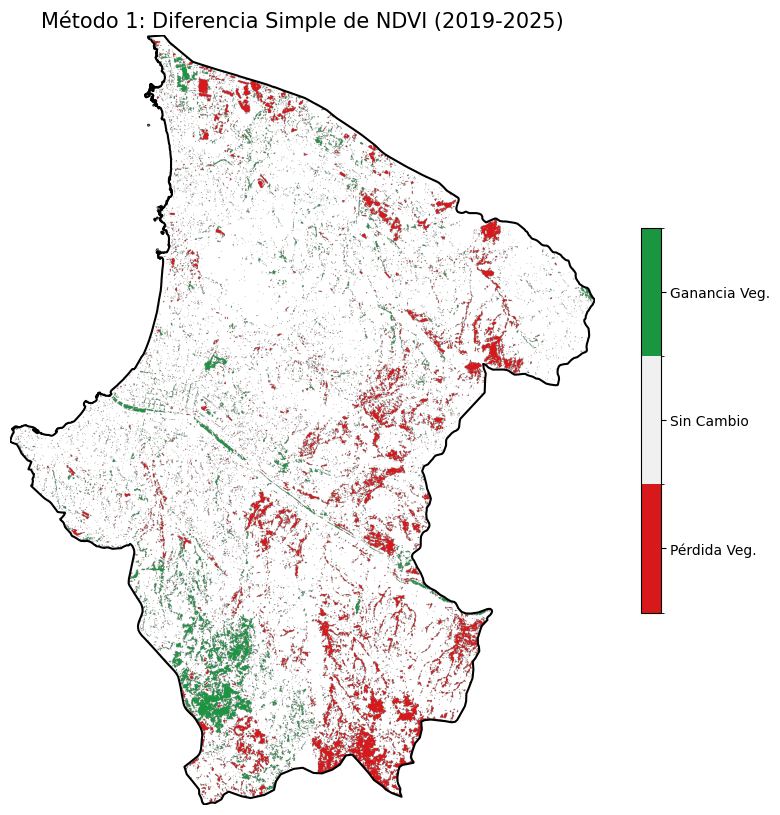

In [3]:
# Importa la función mask para recortar rasters con geometrías vectoriales
from rasterio.mask import mask
# Importa función para crear transformaciones geoespaciales
from rasterio.transform import from_origin

# Construye la ruta al archivo de diferencia generado por el script
file_diff = processed_dir / f"cambio_diferencia_indices_{YEAR_START}_{YEAR_END}.tif"

# Verifica que el archivo exista antes de procesarlo
if file_diff.exists():
    # Abre el archivo raster en modo lectura
    with rasterio.open(file_diff) as src:
        # --- PREPARACIÓN DEL VECTOR DE RECORTE ---
        # Reproyecta el límite comunal al CRS del raster si es necesario
        if gdf_limite.crs != src.crs:
            gdf_recorte = gdf_limite.to_crs(src.crs)
        else:
            gdf_recorte = gdf_limite

        # --- LECTURA CON RECORTE ESPACIAL ---
        # crop=True: recorta al bounding box de la geometría (zoom a la comuna)
        # nodata=-99: valor para identificar píxeles fuera del límite
        out_image, out_transform = mask(src, gdf_recorte.geometry, crop=True, nodata=-99)
        
        # Extrae la primera banda y convierte a float para usar NaN
        data = out_image[0].astype(float)
        # Convierte el valor nodata a NaN para transparencia en visualización
        data[data == -99] = np.nan 
        
        # --- CÁLCULO DE EXTENSIÓN PARA EL GRÁFICO ---
        # Obtiene dimensiones del array recortado
        height, width = data.shape
        # Calcula las coordenadas geográficas del recorte (left, right, bottom, top)
        extent = [
            out_transform[2],                           # X mínimo (izquierda)
            out_transform[2] + out_transform[0] * width,  # X máximo (derecha)
            out_transform[5] + out_transform[4] * height, # Y mínimo (abajo)
            out_transform[5]                            # Y máximo (arriba)
        ]
        
        # --- CONFIGURACIÓN DEL MAPA DE COLORES CATEGÓRICO ---
        # Define colores: rojo para pérdida, gris para sin cambio, verde para ganancia
        cmap = mcolors.ListedColormap(['#d7191c', '#f0f0f0', '#1a9641'])
        # Define los límites entre categorías (-1.5, -0.5, 0.5, 1.5)
        bounds = [-1.5, -0.5, 0.5, 1.5]
        # Crea normalizador que asigna colores según los límites definidos
        norm = mcolors.BoundaryNorm(bounds, cmap.N)
        
        # --- CREACIÓN DE LA FIGURA ---
        fig, ax = plt.subplots(figsize=(12, 10))
        
        # Plotea el raster con el colormap categórico
        im = ax.imshow(data, cmap=cmap, norm=norm, extent=extent)
        
        # Agrega el borde del límite comunal (sin relleno)
        gdf_recorte.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1.5)
        
        # --- CONFIGURACIÓN DE LA LEYENDA ---
        # Crea barra de color con etiquetas personalizadas
        cbar = plt.colorbar(im, ticks=[-1, 0, 1], shrink=0.5)
        cbar.ax.set_yticklabels(['Pérdida Veg.', 'Sin Cambio', 'Ganancia Veg.'])
        
        # Configura título del mapa
        ax.set_title(f"Método 1: Diferencia Simple de NDVI ({YEAR_START}-{YEAR_END})", fontsize=15)
        # Oculta los ejes de coordenadas para una visualización más limpia
        ax.axis('off')
        
        # --- GUARDADO Y VISUALIZACIÓN ---
        plt.savefig(output_dirs["maps"] / "03_mapa_diferencia_simple.png", dpi=300, bbox_inches='tight')
        plt.show()
else:
    print("✘ Archivo no encontrado.")

##### **4) Método 2: Clasificación de cambio urbano**

En este método, se genera un mapa que muestra los diferentes tipos de cambio detectados combinando NDVI, NDBI y NDWI; los cuales se clasifican como:

- **Gris (0):** Sin cambio significativo
- **Rojo (1):** Urbanización (vegetación a área construida)
- **Naranja (2):** Pérdida de vegetación (no urbana, por ejemplo, incendios)
- **Verde (3):** Ganancia de vegetación (recuperación)
- **Azul (4):** Nuevo cuerpo de agua

A diferencia del método 1 (que solo mide pérdida/ganancia), el método 2 cruza variables (NDVI, NDBI) para categorizar la naturaleza del cambio.

Finalmente, el mapa se guarda en: `outputs/maps/03_mapa_cambio_urbano_clasificado.png`

##### Análisis del mapa del método 2:

Este mapa resultante ofrece una visión mucho más amplia del cambio territorial de Viña del Mar:

1. **Distinción entre "urbanización" y "degradación":** Este es el mayor aporte del método, ya que, mientras que en el Método 1 todo aparecía como una mancha roja uniforme ("pérdida"), aquí se desagrega en dos clases críticas:

- **Urbanización real (clase roja):** Se observa principalmente en los bordes de Reñaca Alto, alrededor de la calle Riñihue, y dichas partes corresponden a zonas donde la vegetación desapareció y a la vez aumentó la señal de construcción (NDBI). Esto indica cambio de uso de suelo irreversible como pavimentación, construcción de viviendas sociales o tomas de terreno consolidadas

- **Pérdida de vegetación no urbana (clase naranja):** Esta clase domina en zonas de cerros o naturaleza que fueron afectadas en el megaincendio de 2024, como los cerros alredor de Vía Las Palmas y algunas partes del jardín botánico. Además, el algoritmo detectó una caída del NDVI pero sin un aumento drástico del NDBI (o un aumento menor al umbral urbano). Esto confirma que lo que ocurrió allí fue una pérdida de biomasa por fuego, dejando suelo quemado o cenizas, pero no necesariamente hormigón. Cabe mencionar que en algunas zonas del incendio (como la del Jardín Botánico) aparecen píxeles rojos, lo que se debe probablemente a la confusión espectral, en otras palabras, el suelo muy quemado y desnudo puede tener una firma espectral similar a la zona urbana en la banda SWIR.

2. **Recuperación vegetacional (clase verde)**: Al igual que en el método anterior, se observa una extensa zona verde en el interior (como parques de la ciudad o alrededor de la Vía las Palmas). El hecho de que esta zona aparezca como "ganancia de vegetación" y no como "nuevo agua" valida que el cambio se debe al vigor fotosintético (lluvias de 2024 contra sequía de 2019) y no a inundaciones.

3. **Cuerpos de agua (clase azul):** La clase "nuevo agua" es prácticamente inexistente o aparece como ruido puntual (píxeles aislados). Esto es consistente con la realidad hidrológica, ya que no se han creado nuevos embalses ni lagunas en la comuna durante este periodo.

4. **Estabilidad (clase gris):** La gran mayoría de la trama urbana consolidada (centro de Viña, población Vergara) permanece en gris, lo que indica que, aunque hubo cambios puntuales (demoliciones o construcciones verticales), la cobertura dominante (impermeable) no cambió a escala de 10 metros.

En conclusión, este método resulta superior al método 1 para la gestión del riesgo, ya que permite separar las zonas de expansión urbana activa (frentes de avance inmobiliario o informal en rojo) de las zonas de desastre o sequía (naranja), que requieren estrategias de restauración ecológica distintas.

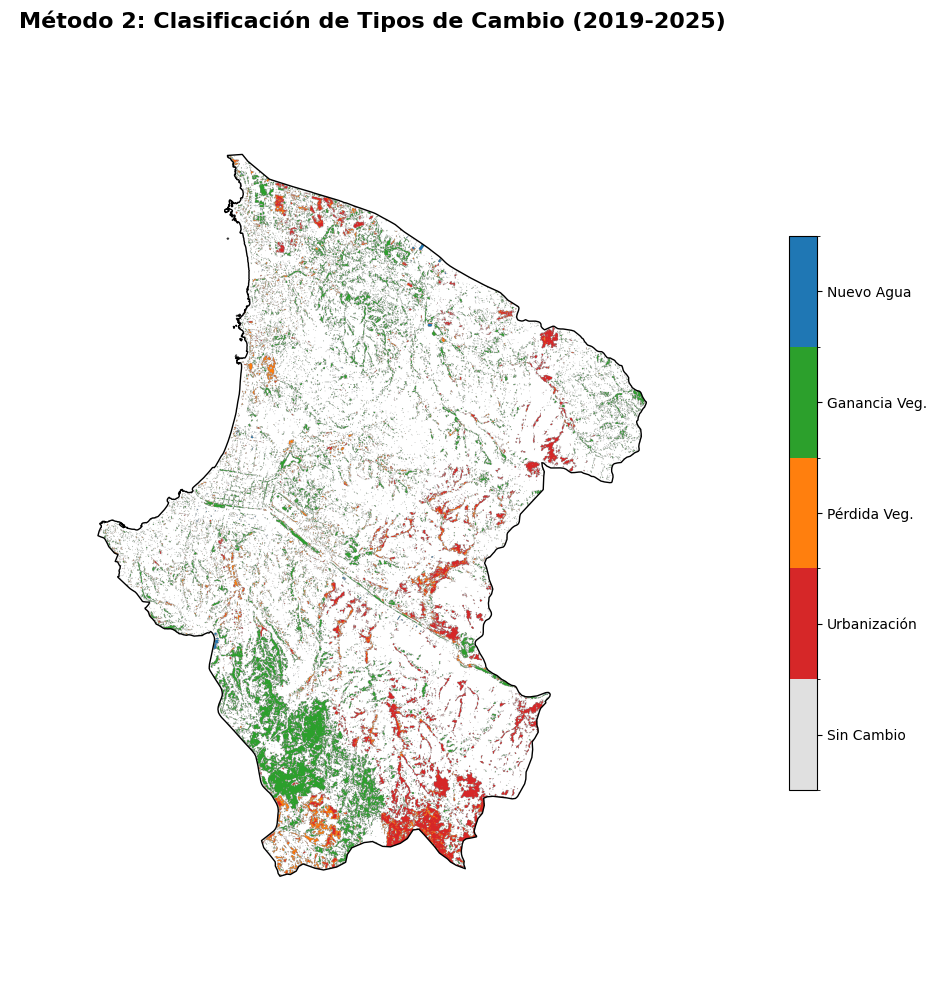

In [8]:
# ruta al archivo de clasificación urbana
file_urban = processed_dir / f"cambio_urbano_{YEAR_START}_{YEAR_END}.tif"

# Verifica que el archivo exista
if file_urban.exists():
    # Abre el archivo raster
    with rasterio.open(file_urban) as src:
        # --- PREPARACIÓN DEL RECORTE VECTORIAL ---
        # Reproyecta si el CRS no coincide
        if gdf_limite.crs != src.crs:
            gdf_recorte = gdf_limite.to_crs(src.crs)
        else:
            gdf_recorte = gdf_limite

        # --- LECTURA CON MÁSCARA ---
        # crop=False mantiene las dimensiones originales
        # nodata=-99 marca los píxeles fuera del límite
        out_image, out_transform = mask(src, gdf_recorte.geometry, crop=False, nodata=-99)
        
        # Convierte a float para usar NaN como valor de fondo transparente
        data = out_image[0].astype(float)
        data[data == -99] = np.nan
        
        # --- CONFIGURACIÓN DE COLORES CATEGÓRICOS ---
        # Define una paleta de 5 colores para las 5 clases
        colors = ['#e0e0e0', '#d62728', '#ff7f0e', '#2ca02c', '#1f77b4']
        # Etiquetas descriptivas para cada clase
        labels = ['Sin Cambio', 'Urbanización', 'Pérdida Veg.', 'Ganancia Veg.', 'Nuevo Agua']
        
        # Crea el mapa de colores discreto
        cmap = mcolors.ListedColormap(colors)
        # Define límites entre clases (centrados en 0, 1, 2, 3, 4)
        bounds = [-0.5, 0.5, 1.5, 2.5, 3.5, 4.5]
        norm = mcolors.BoundaryNorm(bounds, cmap.N)
        
        # --- CREACIÓN DEL MAPA ---
        fig, ax = plt.subplots(figsize=(14, 12))
        
        # Plotea el raster con el mapa de colores categórico
        # plotting_extent calcula automáticamente la extensión del raster
        im = ax.imshow(data, cmap=cmap, norm=norm, extent=rasterio.plot.plotting_extent(src))
        # Superpone el borde del límite comunal
        gdf_recorte.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1)
        
        # --- LEYENDA CATEGÓRICA ---
        # Crea barra de color con ticks en el centro de cada clase
        cbar = plt.colorbar(im, ticks=[0, 1, 2, 3, 4], shrink=0.6)
        cbar.ax.set_yticklabels(labels)
        
        # Configura título con formato destacado
        ax.set_title(f"Método 2: Clasificación de Tipos de Cambio ({YEAR_START}-{YEAR_END})", fontsize=16, fontweight='bold')
        ax.set_axis_off()
        
        # --- GUARDADO Y VISUALIZACIÓN ---
        plt.savefig(output_dirs["maps"] / "03_mapa_cambio_urbano_clasificado.png", dpi=300, bbox_inches='tight')
        plt.show()
else:
    print("✘ Archivo no encontrado.")

##### **5) Método 3: Anomalías temporales (Z-Score)**

Para este método se generó un mapa de calor que muestra las anomalías de vegetación del año objetivo respecto al promedio histórico. En donde el Z-Score indica cuántas desviaciones estándar se desvía el valor actual de la media histórica:
- **Rojo (Z < -2):** Anomalía negativa (menos vegetación de lo normal)
- **Amarillo (Z ≈ 0):** Comportamiento normal
- **Verde (Z > 2):** Anomalía positiva (más vegetación de lo normal)

Cabe mencionar que, este método es especialmente útil para detectar cambios que se desvían del patrón estacional típico, identificar áreas de estrés hídrico o degradación gradual y filtrar variaciones climáticas normales

El mapa correspondiente al método 3 se guardó en: `outputs/maps/03_mapa_anomalias_zscore.png`

##### Análisis del mapa del método 3:

Este mapa ofrece una perspectiva estadística del cambio, identificando qué tan inusual es el valor de vegetación de 2025 comparado con la historia reciente (2019-2024). En este mapa se pueden observar los siguientes casos:

1. **Anomalías negativas extremas (rojo intenso, Z < -2):** Al igual que en los métodos anteriores, hay partes del Jardín Botánico que aparecen en rojo profundo, además, se intensificaron las manchas rojas en las zonas cercanas a Reñaca Alto, indicando pérdida de vegetación. En este método, la señal es mucho más fuerte y limpia que en el método 1, porque históricamente (línea base), esa zona tenía una vegetación muy estable y densa. La perturbación de 2025 rompe tan drásticamente con ese patrón histórico que el algoritmo lo marca como un evento estadísticamente extremo (una anomalía severa), separándolo del ruido habitual de cambios menores.  

2. **Anomalías positivas (verde, Z > 1.5):** Gran parte de los cerros no urbanizados, como los de alrededor de Vía Las Palmas, aparecen en tonos verde. Esto no significa necesariamente que haya más bosque que nunca, sino que la vegetación en 2025 está significativamente mejor que el promedio histórico. Como la línea base (2019-2024) incluye los peores años de la megasequía, el promedio histórico es bajo. Por lo tanto, un año normal o bueno en lluvias como el 2024-2025 aparece estadísticamente como una anomalía positiva (recuperación).

3. **Comportamiento neutral (amarillo, Z ≈ 0):** La trama urbana consolidada se mantiene en amarillo, sectores como Las Cucharas. Esto indica que el NDVI de 2025 es muy similar al promedio histórico en esas zonas. A diferencia del Método 1, que mostraba mucho ruido gris o verde en la ciudad por pequeñas variaciones, el Z-Score apaga esas variaciones irrelevantes, dejando en amarillo todo lo que se comporta dentro de lo esperado.

En conclusión, este es el método más robusto para diferenciar eventos catastróficos (incendio) de la variabilidad climática. Mientras el incendio genera una anomalía negativa masiva (rojo), la recuperación por lluvias genera una anomalía positiva difusa (verde), permitiendo separar ambos fenómenos en un solo mapa.

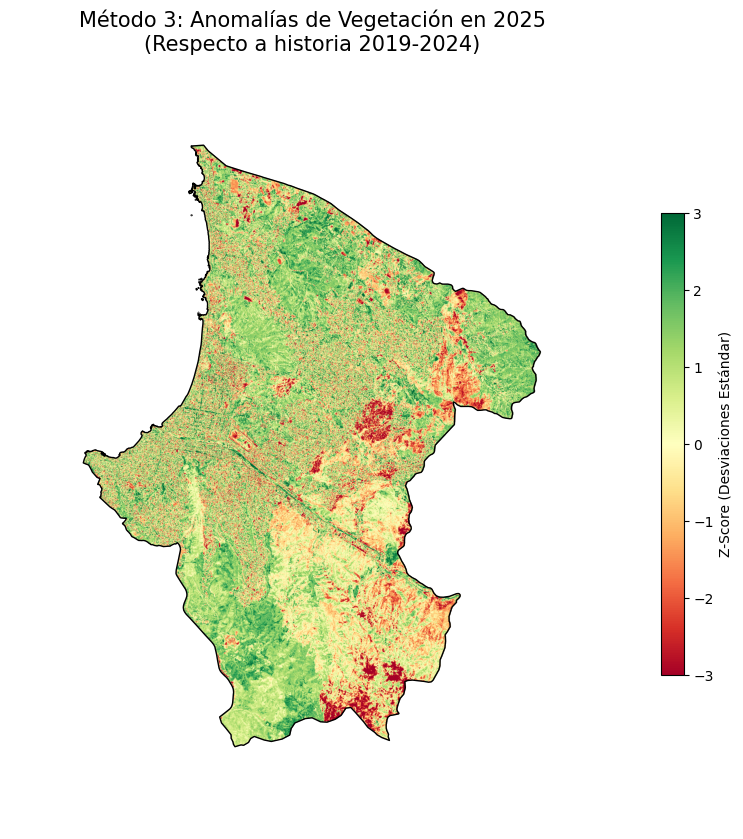

In [4]:
# Construye la ruta al archivo de anomalías del año objetivo
file_anom = processed_dir / f"anomalia_temporal_{YEAR_END}.tif"

# Verifica que el archivo exista
if file_anom.exists():
    # Abre el archivo raster
    with rasterio.open(file_anom) as src:
        # Lee la primera banda (Z-Score de NDVI)
        data = src.read(1)
        
        # --- CORRECCIÓN DEL FONDO ---
        # El script guardó el fondo como 0, lo convertimos a NaN para transparencia
        data[data == 0] = np.nan
        
        # --- FILTROS VISUALES ---
        # Trunca valores extremos para mejorar el contraste visual
        # Valores fuera de [-3, 3] son raros (solo 0.3% en distribución normal)
        data[data < -3] = -3
        data[data > 3] = 3
        
        # --- CREACIÓN DEL MAPA DE CALOR ---
        fig, ax = plt.subplots(figsize=(12, 10))
        
        # Usa colormap divergente RdYlGn (Rojo-Amarillo-Verde)
        # Centrado en 0 (amarillo = normal)
        im = ax.imshow(data, cmap='RdYlGn', vmin=-3, vmax=3, extent=rasterio.plot.plotting_extent(src))
        
        # Superpone el límite comunal reproyectado al CRS del raster
        gdf_limite.to_crs(src.crs).plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1)
        
        # --- BARRA DE COLOR CON ETIQUETA ---
        cbar = plt.colorbar(im, shrink=0.6, label="Z-Score (Desviaciones Estándar)")
        
        # Configura título con contexto histórico
        ax.set_title(f"Método 3: Anomalías de Vegetación en {YEAR_END}\n(Respecto a historia 2019-{YEAR_END-1})", fontsize=15)
        ax.set_axis_off()
        
        # --- GUARDADO Y VISUALIZACIÓN ---
        plt.savefig(output_dirs["maps"] / "03_mapa_anomalias_zscore.png", dpi=300, bbox_inches='tight')
        plt.show()
else:
    print("✘ Archivo no encontrado.")

##### **6) Validación cruzada con datos externos (Google Dynamic World)**

Para evaluar objetivamente la calidad de la detección, se compara el resultado con una fuente de verdad externa (*Ground Truth*).

Se seleccionó el **Método 2 (Clasificación Multiespectral)** para la validación cuantitativa por razones de compatibilidad semántica:
1.  **Naturaleza Categórica:** El método 2 genera clases discretas explícitas (como "Urbanización", "Pérdida de Vegetación"). Esto es directamente comparable con las clases de cobertura de suelo de *Dynamic World* (como "Built Area").
2.  **Incompatibilidad de otros métodos:** El método 1 (diferencia) entrega valores continuos de pérdida o ganancia de vigor, pero no distingue si la pérdida se debe a un edificio o a un incendio. Compararlo con "Urbanización" generaría errores conceptuales. Y el método 3 (anomalía) es estadístico (Z-Score), en donde una anomalía indica rareza, no tipo de cobertura.

**Protocolo de Validación:**
* **Ground Truth:** Se define como "Cambio Urbano Real" a los píxeles que en 2019 **no** eran construidos (Clase $\neq$ 6 en Dynamic World) y en 2025 **SÍ** lo son (Clase = 6).
* **Predicción:** Se toma la Clase 1 ("Urbanización") del método 2.

**Proceso:**
1. Descarga automática de clasificaciones Dynamic World (2019, 2025)
2. Cálculo de "cambio urbano real" según Dynamic World
3. Comparación con nuestra predicción (Método 2)
4. Generación de matriz de confusión y métricas de precisión

**Métricas calculadas:**
* **Precisión:** TP / (TP + FP) - ¿Cuántos de los detectados son reales?
* **Recall:** TP / (TP + FN) - ¿Cuántos de los reales fueron detectados?
* **F1-Score:** Media armónica de precisión y recall

Finalmente, la matriz de confusión se guardó en las rutas `outputs/figures/03_matriz_confusion.png` y `outputs/reports/03_matriz_confusion.csv`

##### Análisis de resultados de validación:

La matriz de confusión y las métricas derivadas revelan las limitaciones técnicas de usar índices espectrales simples (NDBI) en zonas semiáridas.

1. **Interpretación de la matriz de confusión**
* **Verdaderos negativos (69,055):** La gran mayoría del territorio fue correctamente identificado como "No Urbano". Por ende, el modelo es robusto en zonas estables.
* **Falsos positivos (25,030):** Este es el dato más crítico. El modelo clasificó como "Nueva Urbanización" a 25 mil píxeles que Google dice que NO son edificios. Esto confirma la **confusión espectral** detectada en el Notebook 02 de cálculo de índices. El suelo desnudo de los cerros (muy seco en verano de 2025) refleja intensamente en la banda SWIR, engañando al índice NDBI y haciéndolo pasar por concreto.
* **Verdaderos positivos (2,363):** Se detectaron correctamente 2,363 píxeles de nueva construcción real.

2. **Análisis de Métricas**
* **Precisión (9%):** Extremadamente baja. Indica que de cada 10 alertas de "nueva casa" que genera nuestro modelo, solo 1 es real y 9 son "falsa alarma" (probablemente suelo seco). Esto implica que el Método 2 sobreestima masivamente la expansión urbana.
* **Recall (40%):** Moderado, lo que indica que el modelo fue capaz de encontrar el 40% de las construcciones nuevas reales. Es decir, es relativamente sensible, pero muy poco específico.


En conclusión, la validación demuestra que, en climas mediterráneos secos como Viña del Mar, no basta con umbrales simples de NDBI para detectar ciudad. Además, la sequía introduce demasiado "ruido". Entonces, el Método 2 es útil como herramienta de "screening" (búsqueda amplia), pero requiere una limpieza manual posterior o el uso de índices más complejos (como clasificaciones supervisadas con Machine Learning) para filtrar el suelo desnudo y mejorar esa precisión del 9%.

➤ Verificando/Descargando datos de validación (Dynamic World)...
➤ Los datos de validación se guardarán en: D:\laboratorio_cambio_urbano\data\validation
✔ GEE inicializado.
➤ Descargando datos de validación (Dynamic World)...
✔ [YA EXISTE] reference_lulc_2019.tif
✔ [YA EXISTE] reference_lulc_2025.tif

✔ ✔ Datos de validación listos.

✔ Datos de validación listos.

✔ Generando Matriz de Confusión...


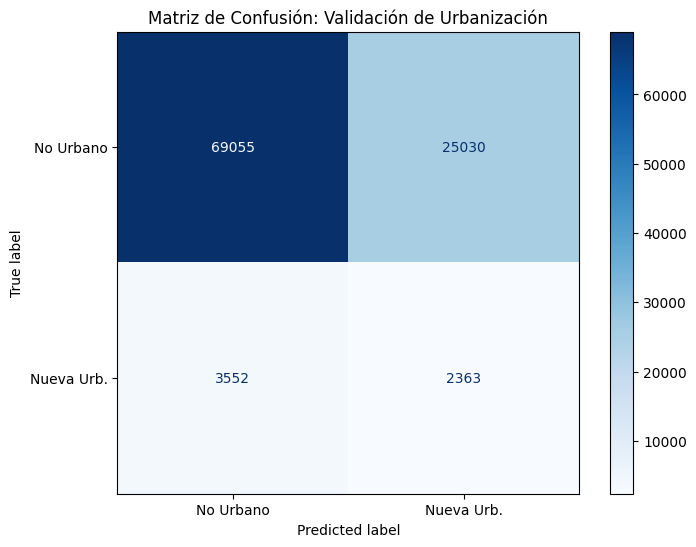

✔ Matriz guardada en CSV: D:\laboratorio_cambio_urbano\outputs\reports\03_matriz_confusion.csv
------------------------------
➤ Precisión (Accuracy de Urbanización): 0.09
➤ Recall (Sensibilidad): 0.40
➤ F1-Score: 0.14
------------------------------


In [ ]:
# Importa métricas de evaluación de scikit-learn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Importa pandas para manejo de datos tabulares
import pandas as pd

# ==============================================================================
# PASO 1: DESCARGA AUTOMÁTICA DE DATOS DE VALIDACIÓN
# ==============================================================================
print("➤ Verificando/Descargando datos de validación (Dynamic World)...")

# Ruta al script de descarga de datos de validación
script_val = project_root / "scripts" / "download_validation.py"

# Construye el comando usando el Python del kernel activo
cmd_val = [sys.executable, str(script_val)]
# Ejecuta con encoding UTF-8 para manejar emojis en Windows
result_val = subprocess.run(cmd_val, capture_output=True, text=True, encoding="utf-8", errors="replace")

# Verifica el resultado de la descarga
if result_val.returncode != 0:
    print("✘ Error descargando validación:")
    print(result_val.stderr)
else:
    print(result_val.stdout)
    print("✔ Datos de validación listos.")

# ==============================================================================
# PASO 2: CÁLCULO DE MATRIZ DE CONFUSIÓN
# ==============================================================================
print("\n✔ Generando Matriz de Confusión...")

# Define rutas a los archivos de referencia de Dynamic World
ref_2019_path = project_root / "data" / "validation" / "reference_lulc_2019.tif"
ref_2025_path = project_root / "data" / "validation" / "reference_lulc_2025.tif"

# Verifica que ambos archivos de referencia existan
if ref_2019_path.exists() and ref_2025_path.exists():
    # Abre ambos archivos de referencia simultáneamente
    with rasterio.open(ref_2019_path) as src1, rasterio.open(ref_2025_path) as src2:
        # Recorta los rasters de referencia al límite comunal
        ref_2019, _ = mask(src1, gdf_limite.geometry, crop=True)
        ref_2025, _ = mask(src2, gdf_limite.geometry, crop=True)
        
        # Aplana los arrays 3D a 1D para comparación píxel a píxel
        y_2019 = ref_2019[0].flatten()
        y_2025 = ref_2025[0].flatten()
        
        # --- DEFINICIÓN DEL GROUND TRUTH (VERDAD) ---
        # Cambio Urbano Real: NO era Urbano (clase 6) en 2019 Y SÍ es Urbano en 2025
        # Nota: En Dynamic World, clase 6 = "Built" (Construido/Urbano)
        cambio_real = np.zeros_like(y_2019, dtype=int)
        mask_urbanizacion_real = (y_2019 != 6) & (y_2025 == 6)
        cambio_real[mask_urbanizacion_real] = 1  # 1 = Cambio urbano real detectado
        
    # --- CARGA DE LA PREDICCIÓN (MÉTODO 2) ---
    if file_urban.exists():
        with rasterio.open(file_urban) as src_pred:
            # Recorta la predicción al mismo extent
            pred_img, _ = mask(src_pred, gdf_limite.geometry, crop=True, nodata=-99)
            y_pred_map = pred_img[0].flatten()
            
            # Simplifica a clasificación binaria:
            # 1 = Urbanización detectada (Clase 1 del Método 2)
            # 0 = Otro tipo de cambio o sin cambio
            y_pred = np.zeros_like(y_pred_map, dtype=int)
            y_pred[y_pred_map == 1] = 1 
            
        # --- FILTRADO Y MUESTREO ALEATORIO ---
        # Filtra píxeles válidos (ignora bordes y nubes)
        valid_pixels = (y_2019 != 0) & (y_pred_map != -99)
        
        # Obtiene índices de píxeles válidos
        indices = np.where(valid_pixels)[0]
        # Muestreo aleatorio si hay muchos píxeles (evita saturar memoria)
        if len(indices) > 100000:
            indices = np.random.choice(indices, 100000, replace=False)
        
        # Extrae muestras para comparación
        y_true_sample = cambio_real[indices]
        y_pred_sample = y_pred[indices]
        
        # --- CÁLCULO Y VISUALIZACIÓN DE MATRIZ ---
        cm = confusion_matrix(y_true_sample, y_pred_sample)
        
        # Crea figura para la matriz de confusión
        fig, ax = plt.subplots(figsize=(8, 6))
        # Usa ConfusionMatrixDisplay para visualización estándar
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Urbano", "Nueva Urb."])
        disp.plot(ax=ax, cmap="Blues", values_format="d")
        ax.set_title("Matriz de Confusión: Validación de Urbanización")
        
        # Guarda la figura
        plt.savefig(output_dirs["figures"] / "03_matriz_confusion.png", bbox_inches='tight')
        plt.show()
        
        # --- EXPORTACIÓN A CSV ---
        # Crea DataFrame con la matriz de confusión
        df_cm = pd.DataFrame(cm, 
                             index=["Real: No Urbano", "Real: Nueva Urb."], 
                             columns=["Pred: No Urbano", "Pred: Nueva Urb."])
        
        # Guarda en CSV
        csv_path = output_dirs["reports"] / "03_matriz_confusion.csv"
        df_cm.to_csv(csv_path)
        print(f"✔ Matriz guardada en CSV: {csv_path}")

        # --- CÁLCULO DE MÉTRICAS DE EVALUACIÓN ---
        # Extrae los 4 componentes de la matriz de confusión
        tn, fp, fn, tp = cm.ravel()
        # Precisión: ¿Qué proporción de detecciones positivas son correctas?
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        # Recall: ¿Qué proporción de casos reales fueron detectados?
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        # F1-Score: Media armónica de precisión y recall
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        # Imprime resumen de métricas
        print("-" * 30)
        print(f"➤ Precisión (Accuracy de Urbanización): {precision:.2f}")
        print(f"➤ Recall (Sensibilidad): {recall:.2f}")
        print(f"➤ F1-Score: {f1:.2f}")
        print("-" * 30)
    else:
        print("✘ No se encontró el archivo de predicción (Método 2). Revisa las celdas anteriores.")

else:
    print("✘ Error crítico: No se pudieron cargar los datos de validación.")

##### **7) Validación visual: Comparación entre el mapa de Ground Truth (Dynamic World) y la predicción del método 2.**

Finalmente, se genera un mapa comparativo para evaluar la coherencia espacial de la detección, el cual muestra visualmente la diferencia entre el Ground Truth (Dynamic World) y la predicción del método 2.

Se utiliza una estrategia de **"superposición de capas" (Layer Sandwich)** para garantizar la legibilidad:
1.  **Fondo (Capa 0):** Lienzo blanco.
2.  **Datos raster (Capa 1):** Píxeles de cambio (Azul para Realidad, Rojo para Predicción). Los valores "No Cambio" se convierten a `NaN` para ser transparentes.
3.  **Límites vectoriales (Capa 2):** Se superpone el polígono de la comuna como un borde negro hueco (`facecolor='none'`). Esto permite visualizar el contexto geográfico sin ocultar los datos subyacentes.

**Estructura del mapa:**
- **Panel izquierdo:** "Realidad" - Cambios reales según Google Dynamic World
- **Panel derecho:** "Predicción" - Cambios detectados por el método 2

El mapa es guardado en `outputs/maps/03_validacion_visual_mapa.png`

##### Análisis del mapa comparativo:

La comparación visual y los conteos de píxeles arrojan un hallazgo fascinante que explica el comportamiento del modelo:

1. **Similitud cuantitativa (volumen):**
* **Píxeles reales (Ground Truth):** 57,084
* **Píxeles Predichos (Modelo):** 58,222
* **Observación:** Los totales son casi idénticos, la diferencia es de apenas un **2%**.
* **Interpretación:** A nivel de "balance de masas", el método 2 parece perfecto. Predice casi exactamente la misma cantidad de hectáreas urbanizadas que Google Dynamic World.

2. **Discrepancia espacial (ubicación):** Aunque las cantidades son iguales, se obtuvo una precisión del 9%. Al observar los mapas lado a lado, se hace evidente el problema:
* **Mapa Izquierdo (realidad - azul):** Muestra patrones de cambio **concentrados y orgánicos**, siguiendo la lógica de expansión de barrios existentes (nuevas calles, ampliaciones de manchas urbanas).
* **Mapa Derecho (predicción - rojo):** Muestra un patrón de **"ruido de sal y pimienta"** disperso por todos los cerros secos de la comuna.

En conclusión, aunque el modelo predijo la cantidad correcta de cambio, falló en la ubicación, detectando suelo desnudo disperso (falsos positivos) en lugar de construcciones concentradas.

En síntesis, este ejercicio demuestra que la teledetección en zonas semiáridas (como Viña del Mar) enfrenta el desafío crítico de la confusión espectral entre suelo y ciudad. Si bien el índice NDBI es útil para estimaciones gruesas, es insuficiente para el mapeo de precisión sin correcciones adicionales. Como futura mejora, para subir esa precisión del 9%, se podría aplicar una máscara de pendiente (las casas no se construyen en pendientes de 45°, el suelo desnudo sí está ahí) o utilizar clasificación supervisada (Machine Learning) en lugar de umbrales simples.

➤ Generando mapa comparativo...
- Píxeles detectados en Ground Truth: 57084.0
- Píxeles detectados en Predicción: 58222.0


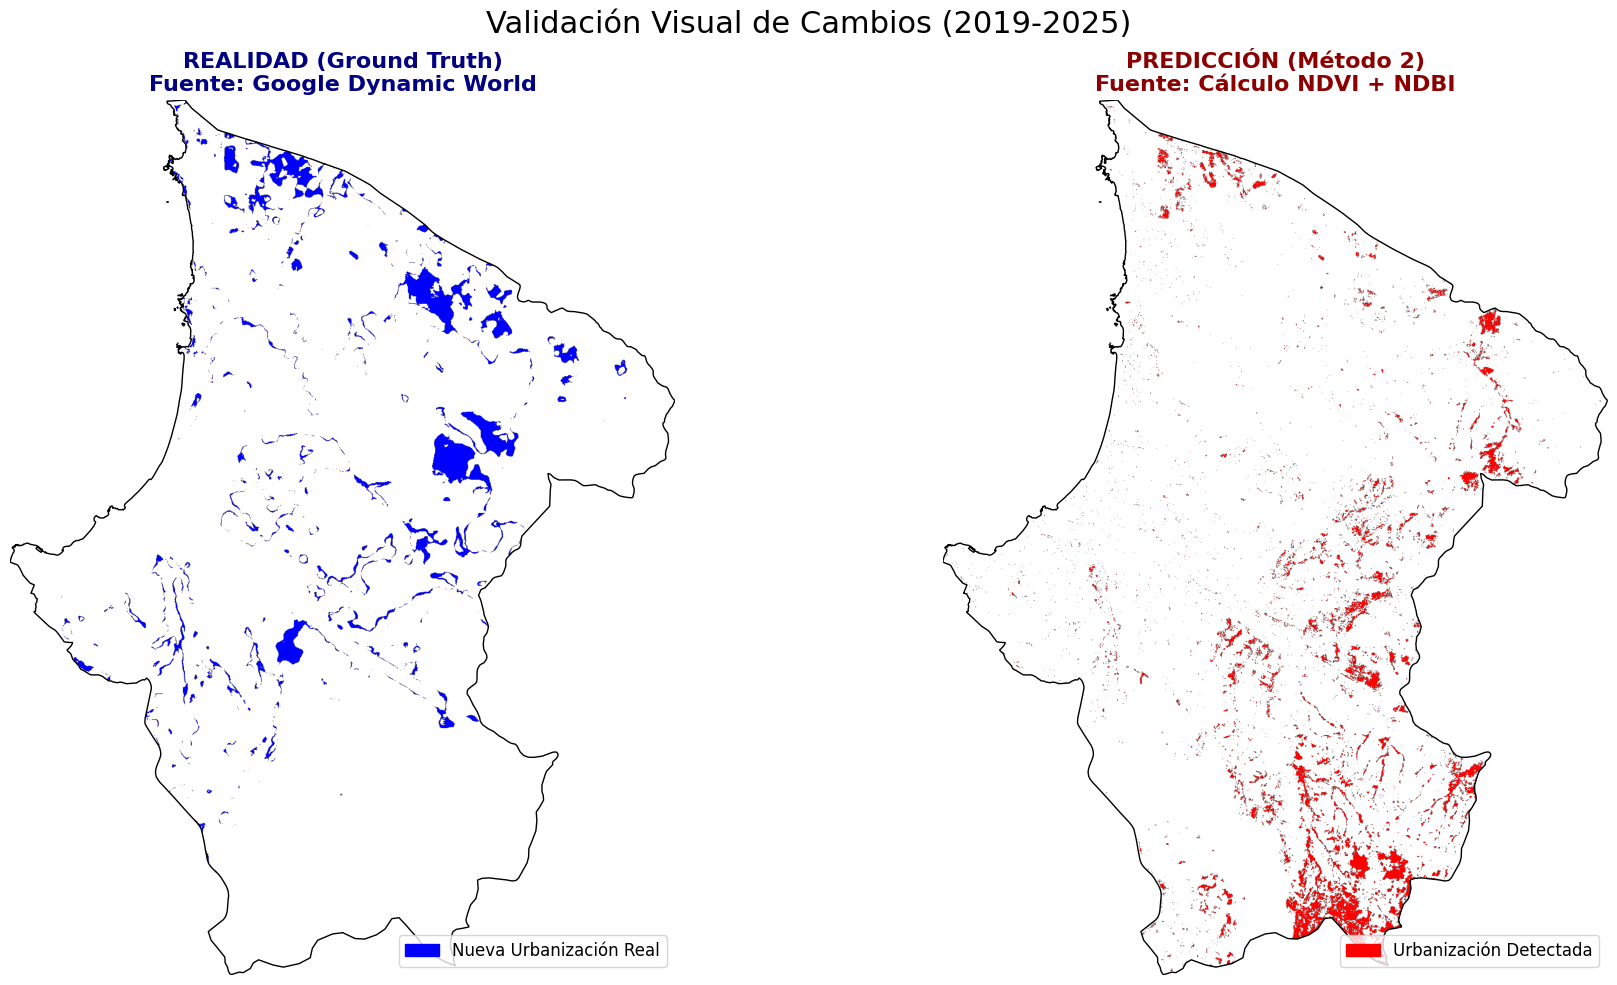

✔ Mapa comparativo guardado en: D:\laboratorio_cambio_urbano\outputs\maps\03_validacion_visual_mapa.png


In [ ]:
# Importa patches para crear elementos de leyenda personalizados
import matplotlib.patches as mpatches
# Importa mask (por si no se cargó en celda anterior)
from rasterio.mask import mask

print("➤ Generando mapa comparativo...")

def get_extent_from_transform(transform, width, height):
    """
    Calcula la extensión geográfica correcta a partir de una transformación afín.
    
    Descripción:
        Convierte los parámetros de una transformación raster (affine transform)
        a coordenadas de extensión para usar en matplotlib imshow.
    
    Entradas:
        transform (Affine): Transformación afín del raster (6 parámetros)
        width (int): Ancho del raster en píxeles
        height (int): Alto del raster en píxeles
    
    Salidas:
        list: [minx, maxx, miny, maxy] - Coordenadas de la extensión
    """
    # Calcula coordenada X mínima (esquina superior izquierda)
    minx = transform[2]
    # Calcula coordenada X máxima (ancho * resolución + origen)
    maxx = transform[2] + (width * transform[0])
    # Calcula coordenada Y máxima (esquina superior izquierda)
    maxy = transform[5]
    # Calcula coordenada Y mínima (alto * resolución negativa + origen)
    miny = transform[5] + (height * transform[4])
    return [minx, maxx, miny, maxy]

# Verifica que existan los archivos necesarios
if 'ref_2019_path' in locals() and ref_2019_path.exists() and file_urban.exists():
    
    # ==========================================================================
    # PREPARACIÓN DE DATOS: GROUND TRUTH (REALIDAD)
    # ==========================================================================
    with rasterio.open(ref_2019_path) as src1, rasterio.open(ref_2025_path) as src2:
        # Reproyecta el límite comunal si es necesario
        if gdf_limite.crs != src1.crs:
            gdf_recorte = gdf_limite.to_crs(src1.crs)
        else:
            gdf_recorte = gdf_limite

        # Lee los rasters recortados al límite comunal
        # crop=True para hacer zoom solo a la comuna
        ref_2019, out_transform = mask(src1, gdf_recorte.geometry, crop=True, nodata=0)
        ref_2025, _ = mask(src2, gdf_recorte.geometry, crop=True, nodata=0)
        
        # Calcula la extensión geográfica del recorte
        h, w = ref_2019[0].shape
        extent_gt = get_extent_from_transform(out_transform, w, h)
        
        # Calcula el mapa de cambio real (Ground Truth)
        # Cambio real = No era urbano en 2019 Y es urbano en 2025
        cambio_real_map = np.zeros_like(ref_2019[0], dtype=float)
        mask_real = (ref_2019[0] != 6) & (ref_2025[0] == 6) & (ref_2019[0] != 0)
        cambio_real_map[mask_real] = 1
        # Convierte 0 a NaN para transparencia
        cambio_real_map[cambio_real_map == 0] = np.nan 

    # ==========================================================================
    # PREPARACIÓN DE DATOS: PREDICCIÓN (MÉTODO 2)
    # ==========================================================================
    with rasterio.open(file_urban) as src_pred:
        # Lee el raster de predicción recortado
        pred_img, out_transform_pred = mask(src_pred, gdf_recorte.geometry, crop=True, nodata=-99)
        pred_data = pred_img[0].astype(float)
        
        # Calcula extensión del recorte
        h_p, w_p = pred_data.shape
        extent_pred = get_extent_from_transform(out_transform_pred, w_p, h_p)
        
        # Extrae solo la clase de urbanización (clase 1)
        pred_urban = np.zeros_like(pred_data)
        pred_urban[pred_data == 1] = 1
        # Convierte 0 a NaN para transparencia
        pred_urban[pred_urban == 0] = np.nan 

    # --- DIAGNÓSTICO RÁPIDO ---
    # Muestra conteo de píxeles para verificar que hay datos
    print(f"- Píxeles detectados en Ground Truth: {np.nansum(cambio_real_map)}")
    print(f"- Píxeles detectados en Predicción: {np.nansum(pred_urban)}")

    # ==========================================================================
    # CREACIÓN DEL MAPA COMPARATIVO
    # ==========================================================================
    fig, ax = plt.subplots(1, 2, figsize=(20, 10))
    
    # Define colormaps de un solo color para cada panel
    cmap_google = mcolors.ListedColormap(['blue'])  # Azul para Ground Truth
    cmap_pred   = mcolors.ListedColormap(['red'])   # Rojo para Predicción

    # --- PANEL IZQUIERDO: GROUND TRUTH (REALIDAD) ---
    # Capa 1: El raster de datos (zorder=1 = capa inferior)
    ax[0].imshow(cambio_real_map, cmap=cmap_google, extent=extent_gt, zorder=1)
    # Capa 2: El borde vectorial (zorder=2 = encima, facecolor='none' = sin relleno)
    gdf_recorte.plot(ax=ax[0], facecolor='none', edgecolor='black', linewidth=1, zorder=2)
    # Título con formato destacado
    ax[0].set_title("REALIDAD (Ground Truth)\nFuente: Google Dynamic World", fontsize=16, fontweight='bold', color='navy')
    ax[0].axis('off')
    # Leyenda personalizada
    legend_google = [mpatches.Patch(color='blue', label='Nueva Urbanización Real')]
    ax[0].legend(handles=legend_google, loc='lower right', fontsize=12)

    # --- PANEL DERECHO: PREDICCIÓN (MÉTODO 2) ---
    # Capa 1: El raster de predicción
    ax[1].imshow(pred_urban, cmap=cmap_pred, extent=extent_pred, zorder=1)
    # Capa 2: El borde vectorial (facecolor='none' es clave para no tapar datos)
    gdf_recorte.plot(ax=ax[1], facecolor='none', edgecolor='black', linewidth=1, zorder=2)
    # Título con formato destacado
    ax[1].set_title("PREDICCIÓN (Método 2)\nFuente: Cálculo NDVI + NDBI", fontsize=16, fontweight='bold', color='darkred')
    ax[1].axis('off')
    # Leyenda personalizada
    legend_pred = [mpatches.Patch(color='red', label='Urbanización Detectada')]
    ax[1].legend(handles=legend_pred, loc='lower right', fontsize=12)
    
    # --- TÍTULO GENERAL Y GUARDADO ---
    plt.suptitle(f"Validación Visual de Cambios ({YEAR_START}-{YEAR_END})", fontsize=22, y=0.98)
    plt.tight_layout()
    
    # Guarda el mapa
    save_path = output_dirs["maps"] / "03_validacion_visual_mapa.png"
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"✔ Mapa comparativo guardado en: {save_path}")

else:
    print("✘ Faltan archivos para generar el mapa.")

### **Síntesis Comparativa de Métodos**

A partir de los resultados obtenidos, se presenta un cuadro comparativo de las técnicas implementadas para la detección de cambios en Viña del Mar:

| Método | Enfoque Principal | Ventaja Clave | Limitación Detectada | Recomendación de Uso |
| :--- | :--- | :--- | :--- | :--- |
| **1. Diferencia simple (NDVI)** | Vigor vegetacional | Detecta con alta precisión eventos catastróficos (incendios) y sequía severa. | No observa cambios de uso de suelo que no involucran vegetación verde (como construir sobre tierra seca). | Monitoreo de áreas naturales y forestales. |
| **2. Clasificación urbana** | Cambio de uso de suelo | Categoriza el tipo de cambio (urbanización vs degradación), lo cual es útil para planificación. | Alta tasa de falsos positivos en zonas semiáridas (confusión suelo/urbano) sin corrección por pendiente. | Identificación inicial de expansión urbana. Requiere validación manual. |
| **3. Anomalías (Z-Score)** | Estadística histórica | Robusto frente a la variabilidad estacional. Separa lo normal de lo extraño. | Requiere una serie temporal larga y limpia para calcular una media histórica confiable. | Sistemas de alerta temprana y análisis climático. |

**Conclusión general del estudio:**
La combinación de métodos demostró ser superior al uso de uno solo. Mientras el **método 1** delimitó con precisión la zona del incendio 2024, el **método 2** permitió cuantificar la presión inmobiliaria en los bordes (con las precauciones señaladas por la validación), y el **método 3** contextualizó estos cambios dentro de la crisis hídrica histórica de la región.